In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
def process(x):
    df = x.copy()
    df.date = pd.to_datetime(df.date, unit='s')
    df.views = df.views.replace(-1, np.NaN)
    df.text = df.text.astype('string')
    return df

In [3]:
data = pd.read_parquet('data/news.parq').pipe(process)
data.head()

,date,text,likes,reposts,views,marked_as_ads,group
0,2021-02-18 13:38:33,Каждая культура приписывает женщинам и мужчина...,56,40,16606.0,False,batenka_ru
1,2021-03-23 17:24:00,Интимные фотографии регулярно утекают в сеть и...,33,22,8476.0,False,batenka_ru
2,2021-03-15 12:45:47,Мы продолжаем изучать современные гендерные ст...,35,8,9374.0,False,batenka_ru
3,2021-03-13 06:00:02,В эти выходные наши друзья из InLiberty провод...,7,5,8135.0,False,batenka_ru
4,2021-03-11 18:05:35,​​В феврале мы провели исследование и опросили...,25,10,9860.0,False,batenka_ru


In [4]:
mem_usg = data.memory_usage(deep=True) / 1024 ** 2
mem_usg

Index             0.000122
date             10.087852
text             10.087852
likes            10.087852
reposts          10.087852
views            10.087852
marked_as_ads     1.260982
group             1.262729
dtype: float64

Text(0, 0.5, 'posts')

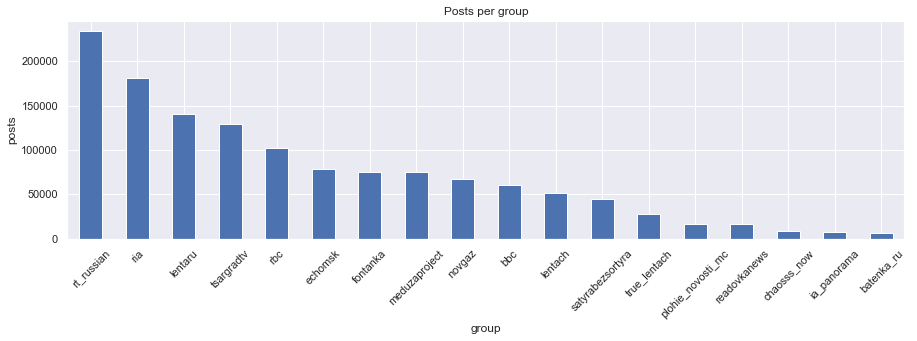

In [6]:
data.group.value_counts().plot.bar(figsize=(15, 4))
plt.xticks(rotation=45)
plt.title('Posts per group')
plt.xlabel('group')
plt.ylabel('posts')

In [7]:
# Likes, reposts, views statistics
(
    data.describe(percentiles=np.arange(0, 1, .1))
        .round()
        .astype('int64'))

,likes,reposts,views
count,1322235,1322235,876770
mean,322,20,40868
std,984,99,104412
min,0,0,21
0%,0,0,21
10%,11,0,3082
20%,19,1,5605
30%,28,2,8675
40%,43,3,11380
50%,65,5,14998


In [76]:
FIGSIZE = (15, 6)
FIGSIZE1 = (10, 4)

Text(0.5, 1.0, 'Likes distribution')

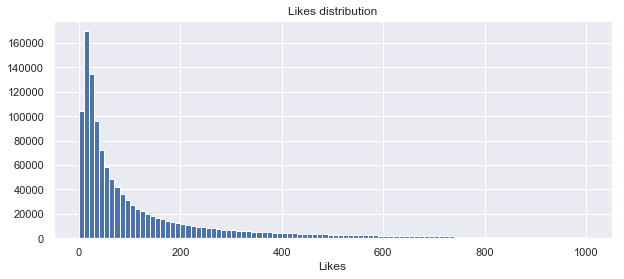

In [77]:
data.likes.hist(bins=100, range=(0, 1000), figsize=FIGSIZE1)
plt.xlabel('Likes')
plt.title('Likes distribution')

Text(0.5, 1.0, 'Reposts distribution')

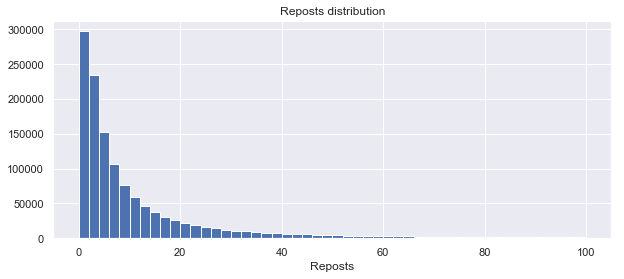

In [78]:
data.reposts.hist(bins=50, range=(0, 100), figsize=FIGSIZE1)
plt.xlabel('Reposts')
plt.title('Reposts distribution')

Text(0.5, 1.0, 'Views distribution')

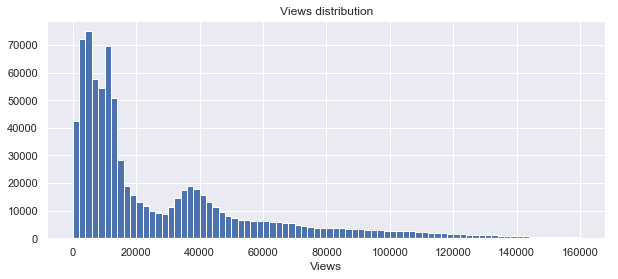

In [79]:
(
    data.views
        .hist(bins=80, range=(0, 160000), figsize=FIGSIZE1))
plt.xlabel('Views')
plt.title('Views distribution')

In [80]:
data.marked_as_ads.value_counts(normalize=True)

False    0.999362
True     0.000638
Name: marked_as_ads, dtype: float64

Text(0, 0.5, 'Mean like')

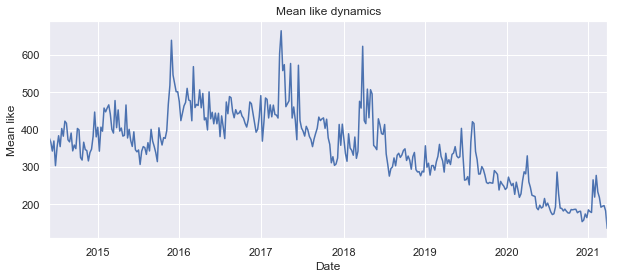

In [81]:
(
    data.groupby(pd.Grouper(key='date', freq='w'))
        .likes
        .mean()['2014-06-01': ]
        .plot(figsize=FIGSIZE1)
)

plt.title('Mean like dynamics')
plt.xlabel('Date')
plt.ylabel('Mean like')

Text(0, 0.5, 'Mean reposts')

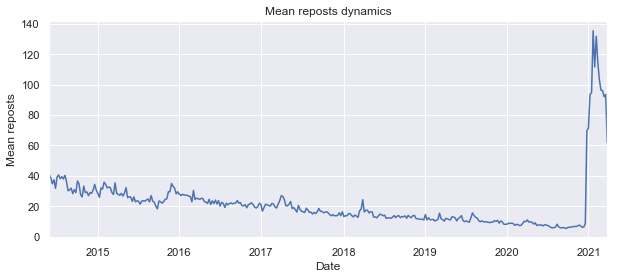

In [82]:
(
    data.groupby(pd.Grouper(key='date', freq='w'))
        .reposts
        .mean()['2014-06-01': ]
        .plot(figsize=FIGSIZE1))

plt.title('Mean reposts dynamics')
plt.xlabel('Date')
plt.ylabel('Mean reposts')

Text(0, 0.5, 'Mean views')

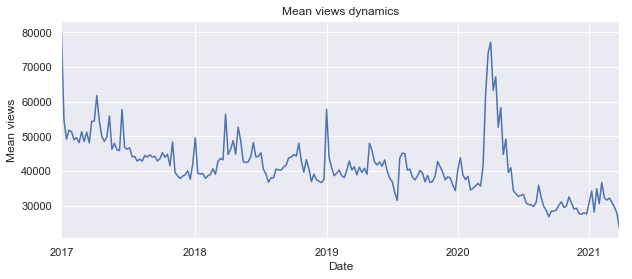

In [83]:
(
    data.groupby(pd.Grouper(key='date', freq='w'))
        .views
        .mean()['2017-01-01': ]
        .plot(figsize=FIGSIZE1)
)
plt.title('Mean views dynamics')
plt.xlabel('Date')
plt.ylabel('Mean views')

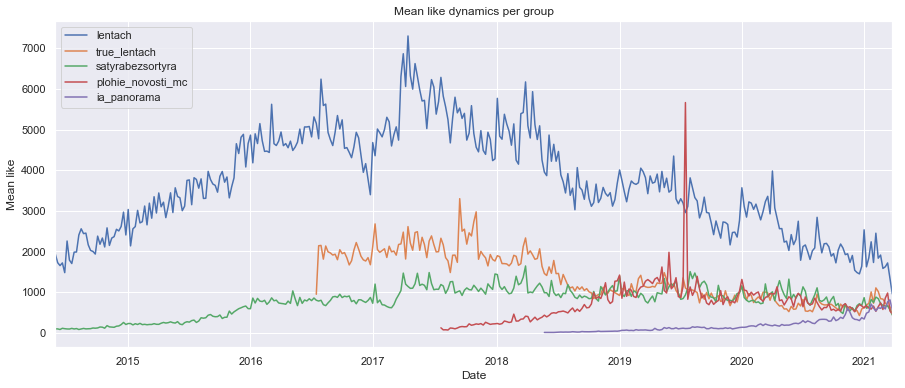

In [84]:
dynamics = data.pivot_table(
    index=pd.Grouper(key='date', freq='w'), columns='group',
    values='likes', aggfunc='mean'
)['2014-06-01': ]

top = dynamics.last('y').mean().nlargest(5).index
dynamics[top].plot(figsize=FIGSIZE)
plt.title('Mean like dynamics per group')
plt.xlabel('Date')
plt.ylabel('Mean like')
plt.legend(loc='upper left')

In [85]:
dynamics = reposts_dynamics_per_group = data.pivot_table(
    index=pd.Grouper(key='date', freq='w'), columns='group',
    values='reposts', aggfunc='mean'
)['2014-06-01': ]

top = dynamics.last('y').mean().nlargest(5).index

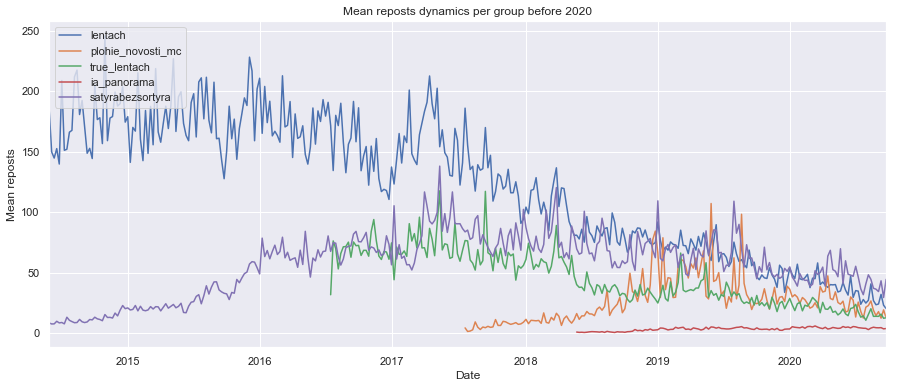

In [86]:
dynamics.loc[:'2020-10-01', top].plot(figsize=FIGSIZE)

plt.title('Mean reposts dynamics per group before 2020')
plt.xlabel('Date')
plt.ylabel('Mean reposts')
plt.legend(loc='upper left')

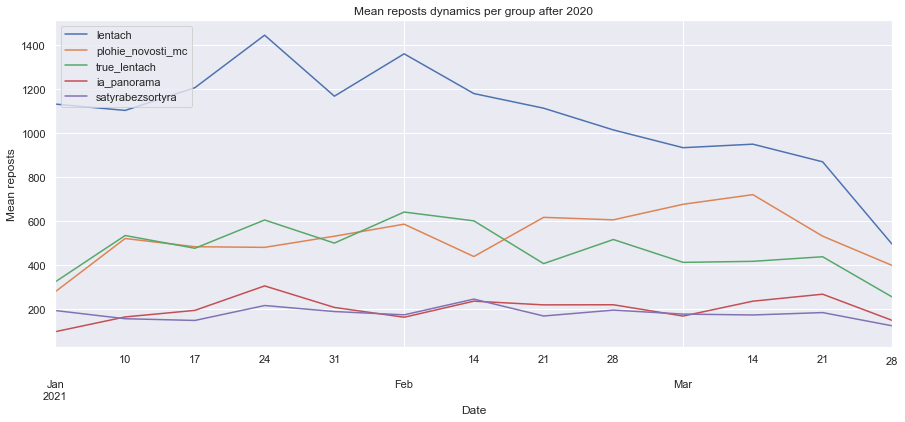

In [87]:
dynamics.loc['2020-12-30':, top].plot(figsize=FIGSIZE)

plt.title('Mean reposts dynamics per group after 2020')
plt.xlabel('Date')
plt.ylabel('Mean reposts')
plt.legend(loc='upper left')

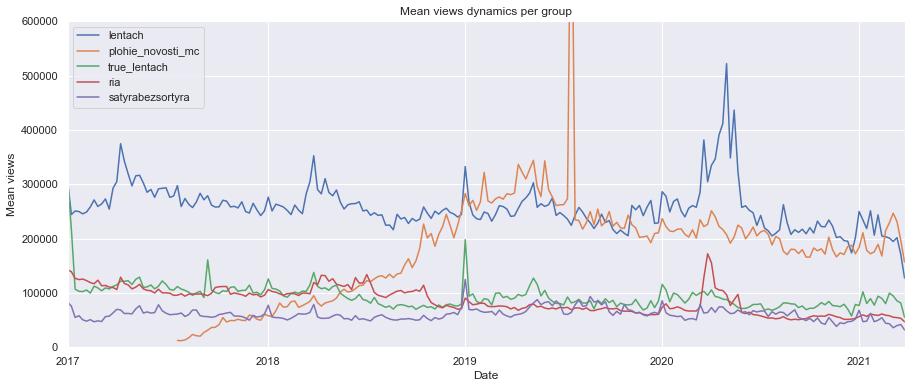

In [88]:
dynamics = data.pivot_table(
    index=pd.Grouper(key='date', freq='w'), columns='group',
    values='views', aggfunc='mean'
)['2017-01-01': ]
top = dynamics.last('y').mean().nlargest(5).index

dynamics[top].plot(figsize=FIGSIZE)

plt.title('Mean views dynamics per group')
plt.xlabel('Date')
plt.ylabel('Mean views')
plt.ylim(0, 6e+5)
plt.legend(loc='upper left')

In [89]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk import download

In [115]:
def count_words(texts, min_df=100, stop_words='russian', vocab=None):
    
    if isinstance(stop_words, str):
        stop_words = stopwords.words(stop_words)
    vect = CountVectorizer(stop_words=stop_words, min_df=100, vocabulary=vocab)
    word_count = vect.fit_transform(texts)
    total_count = np.array(word_count.sum(axis=0))[0]
    total_count = pd.Series(total_count, 
                            pd.Series(vect.vocabulary_).sort_values().index)
    
    return total_count

In [116]:
word_count = count_words(data.text)
top_vocab = word_count.nlargest(5000).index.tolist()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

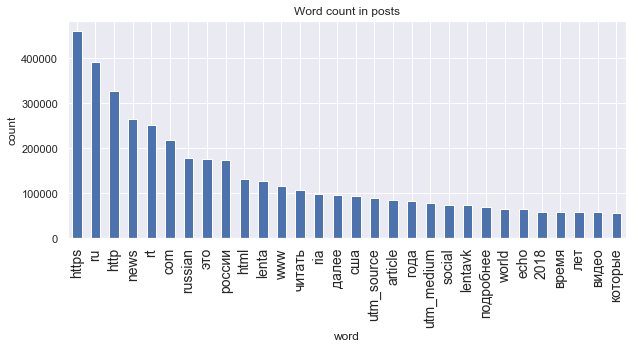

In [132]:
(
    word_count.nlargest(30)
              .plot
              .bar(figsize=FIGSIZE1))
plt.title('Word count in posts')
plt.xlabel('word')
plt.ylabel('count')
plt.xticks(size=14)

In [136]:
word_count_by_month = (
    data.loc[data.date >= '2017-01-01']
        .groupby(pd.Grouper(key='date', freq='m'))
        .text
        .apply(count_words, vocab=top_vocab)
        .unstack(level=1)
)
top_words = word_count_by_month.last('y').mean().nlargest(8).index

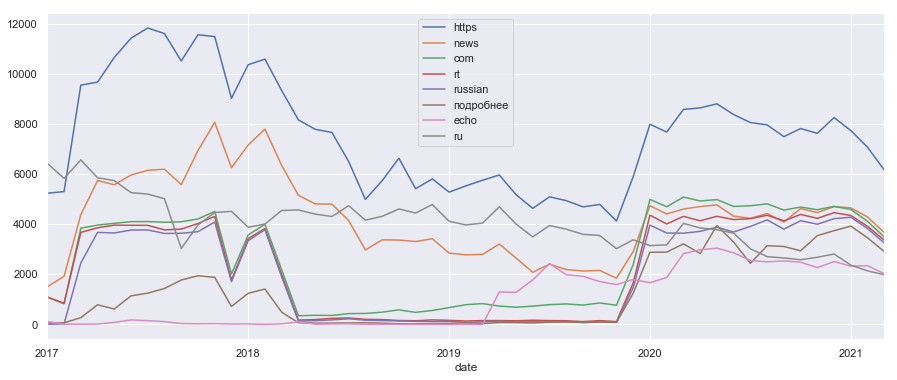

In [138]:
word_count_by_month[top_words].plot(figsize=FIGSIZE)

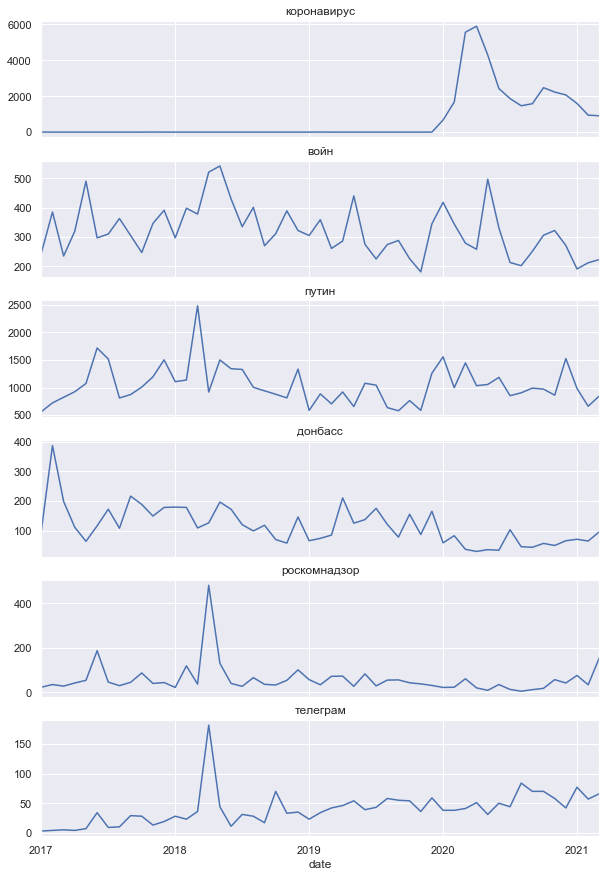

In [143]:
patterns = ['коронавирус','войн', 'путин', 'донбасс', 'роскомнадзор', 'телеграм']

f, ax = plt.subplots(len(patterns), 1, sharex=True)

for ax_i, pat in zip(ax, patterns):

    (
        word_count_by_month.filter(like=pat)
                           .sum(axis=1, skipna=True)
                           .plot(ax=ax_i))
    
    ax_i.set_title(pat)
    
f.set_figheight(len(patterns) * 2.5)
f.set_figwidth(FIGSIZE1[0])